# Section 1: 
  * Load the data into the dataframes 
  * Clean the data and format for better analysis
  * Find out unique companies and rounds details
  * Merge by a common key to generate master dataframe

In [460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

print('---------Checkpoint 1 Start---------')
companies=pd.read_csv('companies.txt',sep="\t", engine='python')
rounds2=pd.read_csv('rounds2.csv', engine='python')
rounds2['company_permalink']= rounds2['company_permalink'].str.encode('utf-8').str.decode('ascii', 'ignore')
companies['name']= companies['name'].str.encode('utf-8').str.decode('ascii', 'ignore')
companies['permalink']= companies['permalink'].str.encode('utf-8').str.decode('ascii', 'ignore')
## To make comparison simple convert the company names to lower case
companies['permalink']=companies['permalink'].str.lower()
rounds2['company_permalink']=rounds2['company_permalink'].str.lower()
companies['name']=companies['name'].str.lower()
print('Find unique details rounds and Company(name,link):',rounds2['company_permalink'].nunique(),companies['name'].nunique(),companies['permalink'].nunique())
# Data Cleaning start 
#Find a duplicated and decide on the index key for company 
companies['name'].fillna( method ='backfill', inplace = True) 
##Find no of rows not present in Rounds table y comparing with company
notprsnt=rounds2[~rounds2['company_permalink'].isin(companies['permalink'])].size
companies.set_index('permalink',inplace=True)
master_frame=pd.merge(rounds2,companies, how='inner', left_on='company_permalink', right_on='permalink')
print('# of observations in MF:',master_frame.shape)
print('---------Checkpoint 1 End-----------\n')

---------Checkpoint 1 Start---------
Find unique details rounds and Company(name,link): 66368 66037 66368
# of observations in MF: (114949, 15)
---------Checkpoint 1 End-----------



## Analyze the funding types - basic level
    * Since the data is in million and define million variable
    * Filter the master frame based on the given investment types 
    * Since it is only 4 investment types, we can just do a manual look up and figure out the best fit for Spark

In [461]:
print('---------Checkpoint 2 Start---------')
oneMillion=1000000
master_frame=master_frame[master_frame['funding_round_type'].isin(['venture','angel','seed','private_equity'])]
avgFunding=master_frame.groupby('funding_round_type')['raised_amount_usd'].mean()/oneMillion
print(avgFunding)
FT='venture'
print('---------Checkpoint 2 End-----------\n')

---------Checkpoint 2 Start---------
funding_round_type
angel              0.958694
private_equity    73.308593
seed               0.719818
venture           11.748949
Name: raised_amount_usd, dtype: float64
---------Checkpoint 2 End-----------



## WIKI Country list 
    * Based on the information provided in WIKI, the top 3 english speaking coutries are chosen
    * For the selected investment type, identify top 9 countries details

In [462]:
#CheckPoint 3
print('---------Checkpoint 3 Start---------')
# Top 3 english countries
top3=pd.DataFrame({'Rank': [1,2,3],
         'code': ['USA', 'GBR', 'IND']})
country1=top3.loc[0].code
country2=top3.loc[1].code
country3=top3.loc[2].code
print('Top 3 English speaking Countries\n',top3)
top9countriesDF=master_frame[master_frame['funding_round_type']==FT].groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False).head(9)
top9countriesDF=top9countriesDF.reset_index()
print('Top 9 Countries details\n',top9countriesDF)
print('---------Checkpoint 3 End-----------\n')

---------Checkpoint 3 Start---------
Top 3 English speaking Countries
    Rank code
0     1  USA
1     2  GBR
2     3  IND
Top 9 Countries details
   country_code  raised_amount_usd
0          USA       4.225108e+11
1          CHN       3.983542e+10
2          GBR       2.024563e+10
3          IND       1.439186e+10
4          CAN       9.583332e+09
5          FRA       7.259537e+09
6          ISR       6.907515e+09
7          DEU       6.346960e+09
8          JPN       3.363677e+09
---------Checkpoint 3 End-----------



## Determining Main sectors
    * Load the mapping file
    * Convert the multi-columns data into a single row 
    * Final outcome to be primary sector to main sector

In [463]:
print('---------Checkpoint 4 Start---------')
#Working with Sectors and analyse the data
## Parse the sector file and convert them as row mapping from column
main_sector=pd.read_csv('mapping.csv', engine='python')
main_sector
main_sector = main_sector.melt(id_vars="category_list",var_name="master_category")
# Convert columns as a sigle colum and remove the non primary sectors
main_sector = main_sector.loc[~(main_sector["value"]==0) ]
main_sector=main_sector.drop(columns="value")
# Remove the blank column
main_sector=main_sector[pd.notnull(main_sector['category_list'])]
print('Main Sector Details:',main_sector.shape) 
print('---------Checkpoint 4 End-----------\n')

---------Checkpoint 4 Start---------
Main Sector Details: (687, 2)
---------Checkpoint 4 End-----------



In [464]:
print('---------Checkpoint 5 Start---------')
startRange=1*oneMillion
maxRange=15*oneMillion
def getPS(sec): 
  return str(sec).split('|')[0]

#print(master_frame.shape)
#print(master_frame.groupby('funding_round_type')['name'].count())
dfByRangeFT=master_frame[master_frame['funding_round_type']==FT]
#print(dfByRangeFT.shape)
dfByRangeFT=dfByRangeFT[(dfByRangeFT['raised_amount_usd']>=startRange) & (dfByRangeFT['raised_amount_usd']<=maxRange )]
dfByRangeFT['primary_sector']=dfByRangeFT['category_list'].apply(getPS)
dfByRangeFT=pd.merge(dfByRangeFT,main_sector, how='left', left_on='primary_sector', right_on='category_list')
dfByRangeFT.rename(columns = {'master_category':'main_sector'}, inplace = True) 
print('no of rows based on FT and range:',dfByRangeFT.shape)

#Create Dataframes based on top3 english speaking countries
D1=dfByRangeFT.loc[dfByRangeFT.country_code==country1]
D2=dfByRangeFT.loc[dfByRangeFT.country_code==country2]
D3=dfByRangeFT.loc[dfByRangeFT.country_code==country3]
print('Country 1 Total investment and  total amount of inst: ',len(D1),(D1['raised_amount_usd'].sum()/oneMillion))
print('Country 2 Total investment and  total amount of inst: ',len(D2),(D2['raised_amount_usd'].sum()/oneMillion))
print('Country 3 Total investment and  total amount of inst: ',len(D3),(D3['raised_amount_usd'].sum()/oneMillion))
top3CountD1=D1.groupby('main_sector')['name'].count().sort_values(ascending=False).head(3)
top3CountD2=D2.groupby('main_sector')['name'].count().sort_values(ascending=False).head(3)
top3CountD3=D3.groupby('main_sector')['name'].count().sort_values(ascending=False).head(3)
top3CountD1=top3CountD1.reset_index()
top3CountD2=top3CountD2.reset_index()
top3CountD3=top3CountD3.reset_index()
print('\nCountry 1 Total count of sector\n',top3CountD1)
print('\nCountry 2 Total count of sector\n',top3CountD2)
print('\nCountry 3 Total count of sector\n',top3CountD3)

topCompanyD1=D1.groupby('name')['raised_amount_usd'].count().sort_values(ascending=False).head(2)
topCompanyD2=D2.groupby('name')['raised_amount_usd'].count().sort_values(ascending=False).head(2)
topCompanyD3=D3.groupby('name')['raised_amount_usd'].count().sort_values(ascending=False).head(2)
print('\nCountry 1 no of inst in 2 topsector\n',topCompanyD1)
print('\nCountry 2 no of inst in 2 topsector\n',topCompanyD2)
print('\nCountry 3 no of inst in 2 topsector\n',topCompanyD3)
print('---------Checkpoint 5 End-----------\n')

---------Checkpoint 5 Start---------
no of rows based on FT and range: (32898, 18)
Country 1 Total investment and  total amount of inst:  23317 136905.653524
Country 2 Total investment and  total amount of inst:  1403 7411.249516
Country 3 Total investment and  total amount of inst:  563 3585.604489

Country 1 Total count of sector
                                main_sector  name
0                                   Others  5489
1               Cleantech / Semiconductors  4467
2  Social, Finance, Analytics, Advertising  3646

Country 2 Total count of sector
                                main_sector  name
0                                   Others   346
1               Cleantech / Semiconductors   284
2  Social, Finance, Analytics, Advertising   230

Country 3 Total count of sector
                                main_sector  name
0                                   Others   185
1               News, Search and Messaging    90
2  Social, Finance, Analytics, Advertising    56

Country 

## Present the analysis for better visuals
    * Plot 1: this is based on global details for the given investment types
    * Plot 2: Top 9 countris total investments
    * Plot 3: Combine top 3 English countries and plot by total counts

---------Checkpoint 6 Start---------


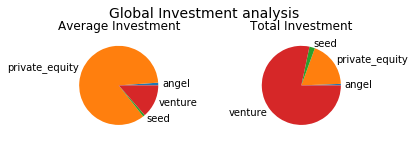

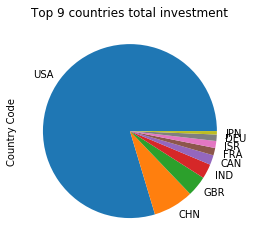

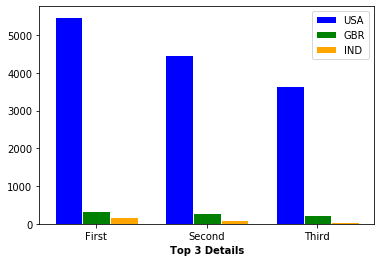

---------Checkpoint 6 End-----------



In [465]:
print('---------Checkpoint 6 Start---------')
the_grid = GridSpec(2, 2)
s1=master_frame.groupby('funding_round_type')['raised_amount_usd'].sum().reset_index()
s2=master_frame.groupby('funding_round_type')['raised_amount_usd'].mean().reset_index() #.sort_values(ascending=False)
plt.subplot(the_grid[0, 1], aspect=1, title='Total Investment')
total_pie = plt.pie(s1['raised_amount_usd'],labels=s1['funding_round_type'],  shadow=False)
plt.subplot(the_grid[0, 0], aspect=1, title='Average Investment') #autopct='%1.1f%%',
avg_pie = plt.pie(s2['raised_amount_usd'],labels=s2['funding_round_type'],shadow=False)
plt.suptitle('Global Investment analysis', fontsize=14)
plt.show()

## Top 9 Countries plot top9countriesDF country_code  raised_amount_usd
plt.pie(top9countriesDF['raised_amount_usd'],labels=top9countriesDF['country_code'],  shadow=False)
plt.title('Top 9 countries total investment')
plt.ylabel('Country Code')
plt.show()

## No of investments in top 3 sectors of the top 3 countries
barWidth = 0.25
r1 = np.arange(len(top3CountD1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, top3CountD1['name'], color='blue', width=barWidth, edgecolor='white', label=country1)
plt.bar(r2, top3CountD2['name'], color='green', width=barWidth, edgecolor='white', label=country2)
plt.bar(r3, top3CountD3['name'], color='orange', width=barWidth, edgecolor='white', label=country3)
 
plt.xlabel('Top 3 Details', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(top3CountD1))], ['First','Second','Third'])
 
# Create legend & Show graphic
plt.legend()
plt.show()
print('---------Checkpoint 6 End-----------\n')

### Comments
    * Prints are added to make the analysis easy
    * Each section has start and end prints for easy identification
    * Each checkpoint in individual cells for easy representation and readability